In [2]:
DEV_PATH = "./dataDev.json"
TEST_PATH = "./dataTest.json"
TRAIN_PATH = "./dataTrain.json"

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tldextract

In [ ]:
df_train = pd.read_json(f"{TRAIN_PATH}")
df_dev = pd.read_json(f"{DEV_PATH}")

df = pd.concat([df_train, df_dev], ignore_index=True)

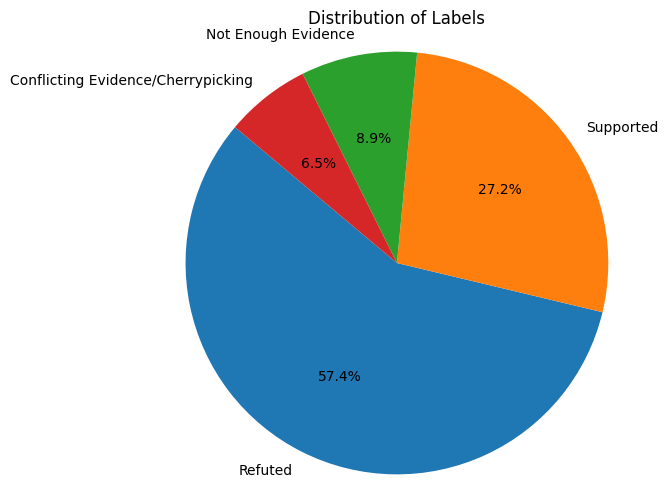

In [5]:
label_counts = df['label'].value_counts()
plt.figure(figsize=(6,6))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140)
plt.title("Distribution of Labels")
plt.axis('equal')
plt.show()


In [6]:
df['reporting_source'] = df['reporting_source'].str.lower().str.strip()

unique_sources = df['reporting_source'].unique().tolist()

print("Unique reporting_source values:")
print(unique_sources)

Unique reporting_source values:
['speech at the republican national convention', 'youtube', 'facebook', 'social media', None, 'twitter', 'abc', 'facebook post', 'youtube: ntv kenya', 'ntv kenya', 'media outlets', 'abc news', 'ntv', 'news24', 'news article', 'the daily mirror', 'taterforce one', 'log cabin republicans pac', '2020 democratic national convention', 'tiktok', 'c-span', 'dnc', 'transcript dnc speech, cnn,', 'line messaging app', 'newsweek', 'facebook - stop anti-white racism', 'facebook,twitter and whatapp', 'the gateway pundit', 'fox sports radio', 'rtvmalacanang, prrd’s statement', 'radio new zealand exerpt and audio file (mark 2min 10sec)', 'national geographic', 'article', 'bbc today programme', 'instagram', 'covidanalysis website', 'https://web.archive.org/web/20210514060602/https://www.axios.com/full-axios-hbo-interview-donald-trump-cd5a67e1-6ba1-46c8-bb3d-8717ab9f3cc5.html', 'axios on hbo', 'wisn-tv', 'brown valley observer', 'msnbc', 'whatsapp', 'newspaper article', 

Unique combined reporting_source values:
['twitter', 'facebook', 'departure speech', 'social media', 'news', None, 'no full stops in india', 'instgram', 'youtube', 'you tube', 'the sun', 'bitchute.com', 'press release', 'whatsapp', 'a public gathering in assam’s nalbari', 'instagram', 'political party debate', 'political party debate.', 'gateway pundit', 'https://web.archive.org/web/20210715123749/https://www.whitehouse.gov/briefing-room/speeches-remarks/2021/03/26/statement-by-president-biden-on-the-attack-on-the-right-to-vote-in-georgia/', 'press confrence', 'instagram post', 'rumble', 'speech in boulder.', 'social media posts', 'website', 'tiktok', 'the quint', 'o dia', 'hindustan times', 'media post', 'courage foundation', 'the epoch times', 'liberty coalition canada', 'interview', 'libertycoalitioncanada', 'nbc’s "meet the press\'\'', 'alliance for advanced health', 'the gateway pundit', 'tv segment', 'senate finance committee hearing', 'science', 'crowderbits', 'infowars', 'pfize

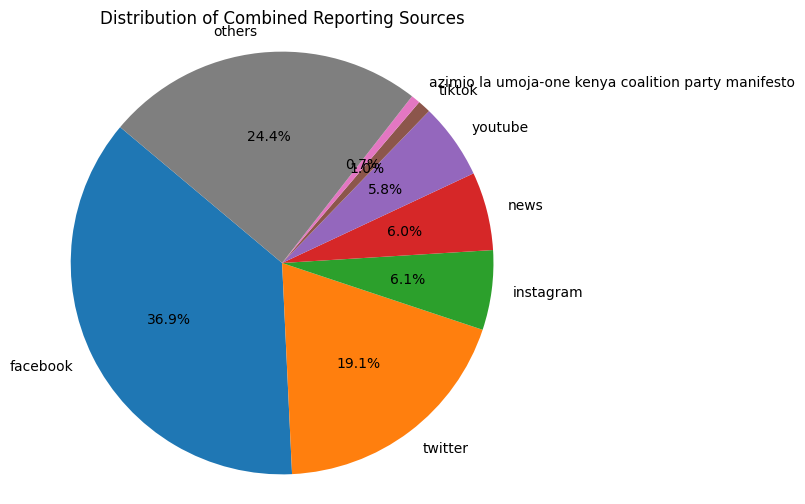

In [15]:
df['reporting_source'] = df['reporting_source'].astype(str).str.lower().str.strip()

def combine_reporting_source(source):
    if pd.isna(source) or source in ['none', '']:
        return None

    if "facebook" in source:
        return "facebook"
    if "youtube" in source:
        return "youtube"
    if "twitter" in source:
        return "twitter"
    if "whatsapp" in source:
        return "whatsapp"

    news_keywords = ["al jazeera", "cnn", "bbc", "fox", "msnbc", "news"]

    for keyword in news_keywords:
        if keyword in source:
            return "news"

    return source

df['reporting_source_combined'] = df['reporting_source'].apply(combine_reporting_source)

unique_sources_combined = df['reporting_source_combined'].unique().tolist()
print("Unique combined reporting_source values:")
print(unique_sources_combined)

report_counts_combined = df['reporting_source_combined'].value_counts()

if len(report_counts_combined) > 7:
    top_5 = report_counts_combined.iloc[:7]
    others = report_counts_combined.iloc[7:].sum()
    new_counts = pd.concat([top_5, pd.Series({'others': others})])
else:
    new_counts = report_counts_combined

plt.figure(figsize=(6,6))
plt.pie(new_counts, labels=new_counts.index, autopct='%1.1f%%', startangle=140)
plt.title("Distribution of Combined Reporting Sources")
plt.axis('equal')
plt.show()


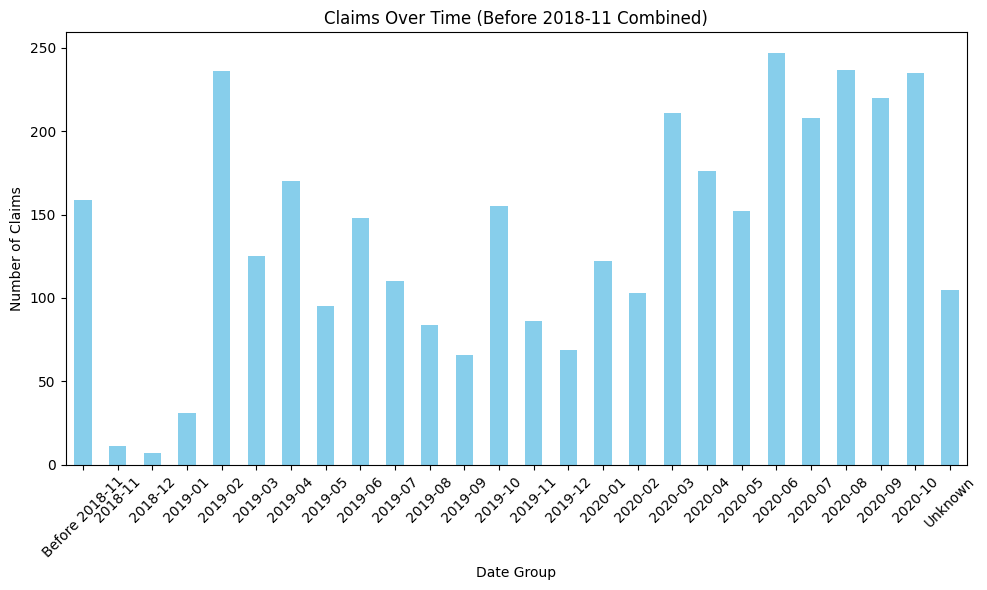

In [8]:
df['claim_date'] = pd.to_datetime(df['claim_date'], dayfirst=True, errors='coerce')

cutoff = pd.to_datetime('2018-11-01')

df['date_group'] = df['claim_date'].apply(
    lambda x: "Before 2018-11" if pd.notna(x) and x < cutoff
    else (x.strftime("%Y-%m") if pd.notna(x) else "Unknown")
)

date_group_counts = df['date_group'].value_counts()

before_count = date_group_counts.get("Before 2018-11", 0)
after_groups = date_group_counts.drop("Before 2018-11", errors='ignore')

after_groups = after_groups.sort_index()

combined_counts = pd.concat([pd.Series({"Before 2018-11": before_count}), after_groups])

plt.figure(figsize=(10,6))
combined_counts.plot(kind='bar', color='skyblue')
plt.xlabel("Date Group")
plt.ylabel("Number of Claims")
plt.title("Claims Over Time (Before 2018-11 Combined)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Summary Statistics for Claim Lengths:
count    3568.000000
mean      103.700673
std        51.594417
min         0.000000
25%        69.000000
50%        93.000000
75%       126.000000
max       392.000000
Name: claim_length, dtype: float64


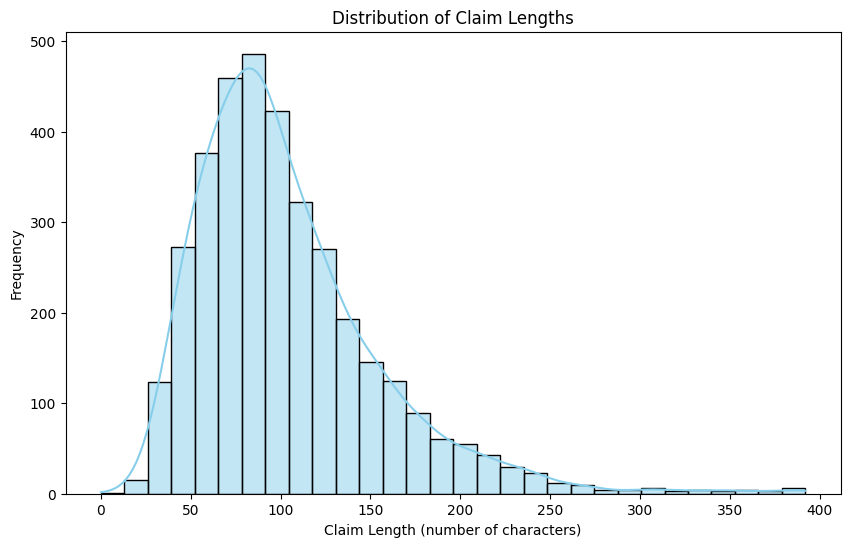

In [9]:
df['claim'] = df['claim'].astype(str)
df['claim_length'] = df['claim'].apply(len)

print("Summary Statistics for Claim Lengths:")
print(df['claim_length'].describe())

plt.figure(figsize=(10, 6))
sns.histplot(df['claim_length'], bins=30, kde=True, color='skyblue')
plt.xlabel("Claim Length (number of characters)")
plt.ylabel("Frequency")
plt.title("Distribution of Claim Lengths")
plt.show()

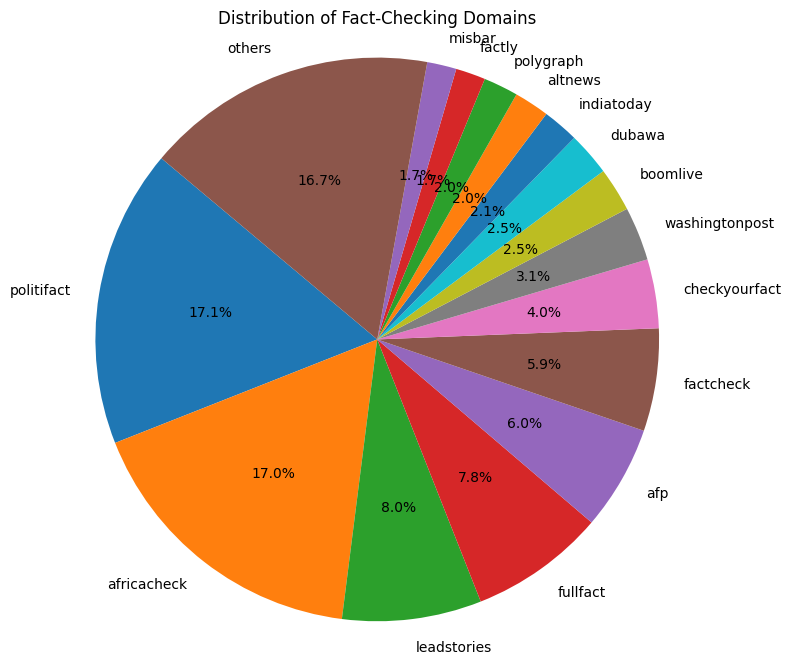

In [10]:
def extract_domain(url):
    if pd.isna(url) or url.strip() == "":
        return None
    if "web.archive.org" in url:
        try:
            parts = url.split('/web/')
            if len(parts) > 1:
                rest = parts[1]
                if '/' in rest:
                    actual_url = rest.split('/', 1)[1]
                    url = actual_url
        except Exception as e:
            pass 

    ext = tldextract.extract(url)
    return ext.domain

df['fact_checking_domain'] = df['fact_checking_article'].apply(extract_domain)

domain_counts = df['fact_checking_domain'].value_counts()

if len(domain_counts) > 15:
    top_10 = domain_counts.iloc[:15]
    others = domain_counts.iloc[15:].sum()
    pie_data = pd.concat([top_10, pd.Series({'others': others})])
else:
    pie_data = domain_counts

plt.figure(figsize=(8,8))
plt.pie(pie_data, labels=pie_data.index, autopct='%1.1f%%', startangle=140)
plt.title("Distribution of Fact-Checking Domains")
plt.axis('equal')  
plt.show()

## Test data analysis


In [ ]:
df_test = pd.read_json(f"{TEST_PATH}")
df = df_test

Unique combined reporting_source values:
['twitter', 'facebook', 'departure speech', 'social media', 'news', None, 'no full stops in india', 'instgram', 'youtube', 'you tube', 'the sun', 'bitchute.com', 'press release', 'whatsapp', 'a public gathering in assam’s nalbari', 'instagram', 'political party debate', 'political party debate.', 'gateway pundit', 'https://web.archive.org/web/20210715123749/https://www.whitehouse.gov/briefing-room/speeches-remarks/2021/03/26/statement-by-president-biden-on-the-attack-on-the-right-to-vote-in-georgia/', 'press confrence', 'instagram post', 'rumble', 'speech in boulder.', 'social media posts', 'website', 'tiktok', 'the quint', 'o dia', 'hindustan times', 'media post', 'courage foundation', 'the epoch times', 'liberty coalition canada', 'interview', 'libertycoalitioncanada', 'nbc’s "meet the press\'\'', 'alliance for advanced health', 'the gateway pundit', 'tv segment', 'senate finance committee hearing', 'science', 'crowderbits', 'infowars', 'pfize

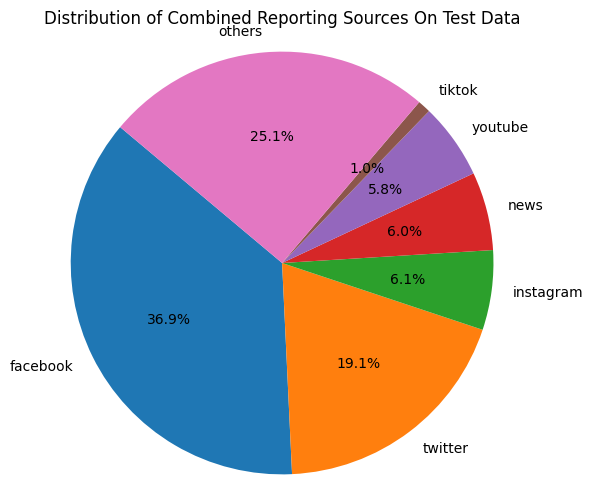

In [12]:
df['reporting_source'] = df['reporting_source'].astype(str).str.lower().str.strip()

def combine_reporting_source(source):
    if pd.isna(source) or source in ['none', '']:
        return None

    if "facebook" in source:
        return "facebook"
    if "youtube" in source:
        return "youtube"
    if "twitter" in source:
        return "twitter"
    if "whatsapp" in source:
        return "whatsapp"

    news_keywords = ["al jazeera", "cnn", "bbc", "fox", "msnbc", "news"]

    for keyword in news_keywords:
        if keyword in source:
            return "news"

    return source

df['reporting_source_combined'] = df['reporting_source'].apply(combine_reporting_source)

unique_sources_combined = df['reporting_source_combined'].unique().tolist()
print("Unique combined reporting_source values:")
print(unique_sources_combined)

report_counts_combined = df['reporting_source_combined'].value_counts()

if len(report_counts_combined) > 6:
    top_5 = report_counts_combined.iloc[:6]
    others = report_counts_combined.iloc[6:].sum()
    new_counts = pd.concat([top_5, pd.Series({'others': others})])
else:
    new_counts = report_counts_combined

plt.figure(figsize=(6,6))
plt.pie(new_counts, labels=new_counts.index, autopct='%1.1f%%', startangle=140)
plt.title("Distribution of Combined Reporting Sources On Test Data")
plt.axis('equal')
plt.show()


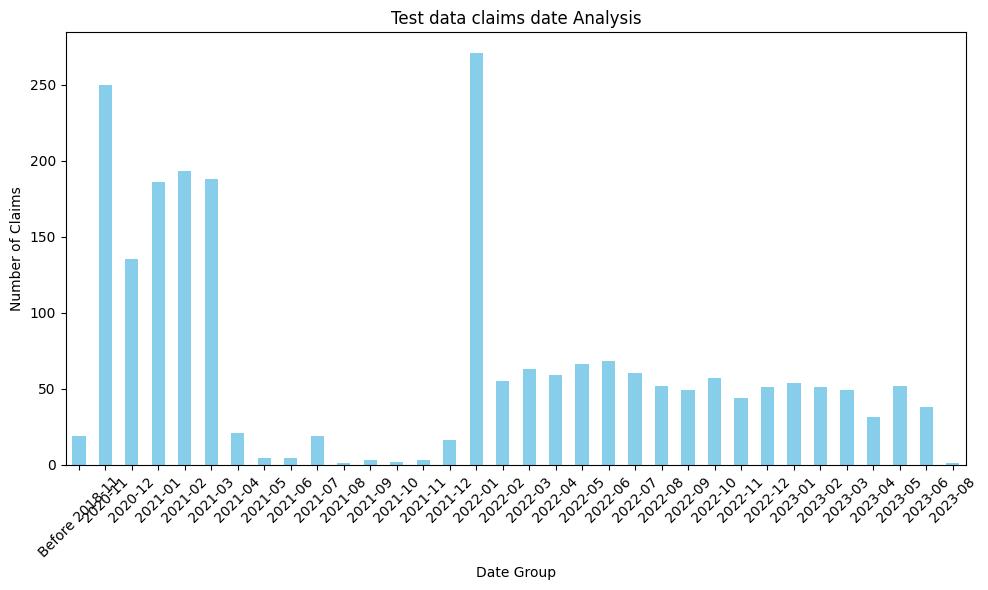

In [13]:
df['claim_date'] = pd.to_datetime(df['claim_date'], dayfirst=True, errors='coerce')

cutoff = pd.to_datetime('2020-09-01')

df['date_group'] = df['claim_date'].apply(
    lambda x: "Before 2018-11" if pd.notna(x) and x < cutoff
    else (x.strftime("%Y-%m") if pd.notna(x) else "Unknown")
)

date_group_counts = df['date_group'].value_counts()

before_count = date_group_counts.get("Before 2018-11", 0)
after_groups = date_group_counts.drop("Before 2018-11", errors='ignore')

after_groups = after_groups.sort_index()

combined_counts = pd.concat([pd.Series({"Before 2018-11": before_count}), after_groups])

plt.figure(figsize=(10,6))
combined_counts.plot(kind='bar', color='skyblue')
plt.xlabel("Date Group")
plt.ylabel("Number of Claims")
plt.title("Test data claims date Analysis")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Summary Statistics for Claim Lengths On Test Data:
count    2215.000000
mean      103.355305
std        50.826944
min        21.000000
25%        69.000000
50%        93.000000
75%       126.000000
max       492.000000
Name: claim_length, dtype: float64


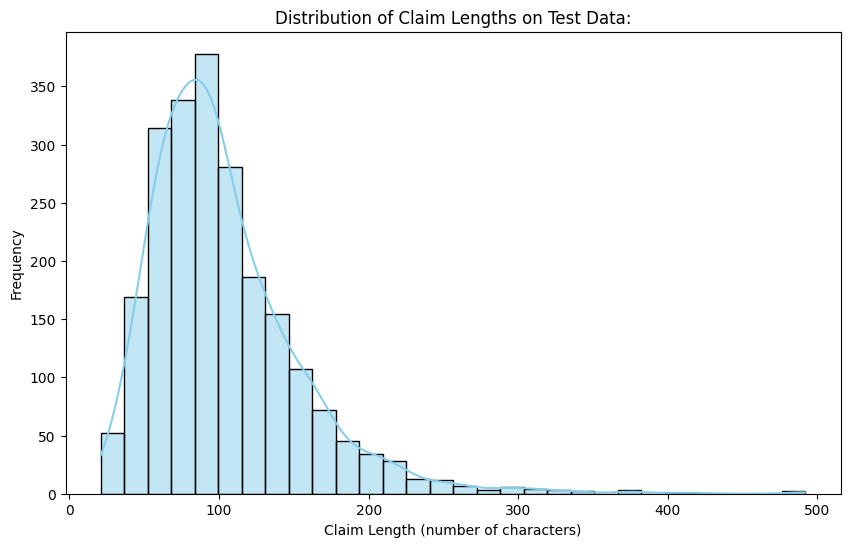

In [14]:
df['claim'] = df['claim'].astype(str)
df['claim_length'] = df['claim'].apply(len)

print("Summary Statistics for Claim Lengths On Test Data:")
print(df['claim_length'].describe())

plt.figure(figsize=(10, 6))
sns.histplot(df['claim_length'], bins=30, kde=True, color='skyblue')
plt.xlabel("Claim Length (number of characters)")
plt.ylabel("Frequency")
plt.title("Distribution of Claim Lengths on Test Data:")
plt.show()